# Assignment 1: detecting offensive content on twitter
**Assignment due 1 March 2025 11:59pm**

Welcome to the first assignment for 50.055 Machine Learning Operations. These assignments give you a chance to practice the methods and tools you have learned. 

**This assignment is an individual assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output, will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster or Google Colab to solve and test the assignment.

**Rubric for assessment** 

Your submission will be graded using the following criteria. 
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. There is a maximum of 76 points for this assignment.


**ChatGPT policy:** 

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


In [1]:
# Installing all required packages
# ----------------
# ! pip install transformers[torch]==4.37.2
# ! pip install evaluate==0.4.1
# ! pip install scikit-learn==1.4.0
# ! pip install datasets==2.17.1
# ! pip install wandb==0.16.3
# ! pip install seaborn==0.13.2
# ! pip install peft==0.10.0
# ! pip install accelerate==0.28.0 
# ----------------

In [1]:
# Importing all required packages
# ----------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

import pandas as pd
import numpy as np
import evaluate
import time

import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
# ----------------

In [2]:
%matplotlib inline

# Offensive language detection

Content moderation of offensive or hateful language is an important task on social media platforms. 
In this assignment, you will train a text classification models for detecting offensive language on twitter. You will run experiments with different models and evaluate their performance and costs.

We will use the TweetEval data set from Barbiert et al (2020): https://aclanthology.org/2020.findings-emnlp.148.pdf


**Warning**
Some of the content contains rude and offensive language. If you know that this causes you distress, let the course instructor know to arrange a different assessment.




In [3]:
dataset = load_dataset("tweet_eval", "offensive")

Using the latest cached version of the dataset since tweet_eval couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'offensive' at C:\Users\ASUS\.cache\huggingface\datasets\tweet_eval\offensive\0.0.0\b3a375baf0f409c77e6bc7aa35102b7b3534f8be (last modified on Mon Feb 24 15:34:07 2025).


In [4]:
# QUESTION: print the first training set sample

#--- ADD YOUR SOLUTION HERE (1 point)---
print("First training sample:")
print(dataset["train"][0])
#------------------------------
# Hint: you should see a tweet about U2 singer Bono

First training sample:
{'text': '@user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen.', 'label': 0}


In [5]:
# QUESTION: what are the possible values of the labels? What is their meaning? 
# Print the set of label values and their label names
#--- ADD YOUR SOLUTION HERE (5 points) ---
# The dataset features include a "label" feature with associated names.
label_names = dataset["train"].features["label"].names
print("Possible label values:", list(range(len(label_names))))
print("Label names:", label_names)
# -------
# Hint: it is a binary task

Possible label values: [0, 1]
Label names: ['non-offensive', 'offensive']


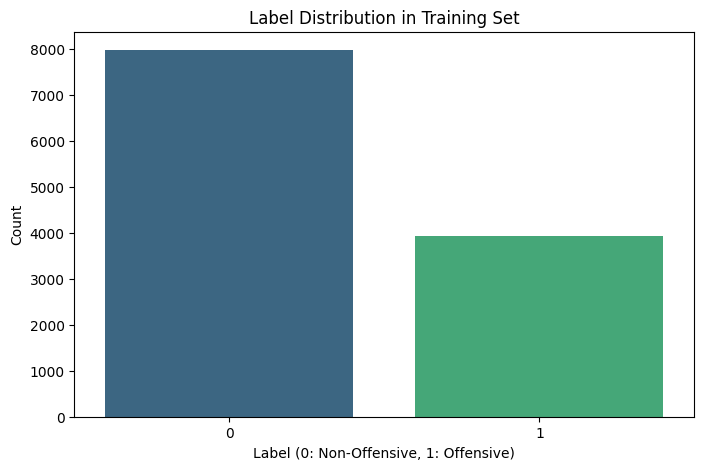

In [6]:
# QUESTION: plot a bar chart of the label distribution
#--- ADD YOUR SOLUTION HERE (5 points) ---

# Convert training split to a DataFrame
train_df = pd.DataFrame(dataset["train"])

# Plot the distribution using seaborn countplot
plt.figure(figsize=(8, 5))
sns.countplot(x="label", data=train_df, hue="label", palette="viridis", legend=False)
plt.title("Label Distribution in Training Set")
plt.xlabel("Label (0: Non-Offensive, 1: Offensive)")
plt.ylabel("Count")
plt.show()

#------------------------------
# Hint: it is not evenly distributed

In [7]:
# QUESTION: separate data set into training, validation and test according to given dataset split
# You should end up with the following variables
# train_text = array containing strings in training set
# train_labels = array containing numeric labels in training set
# validation_text = array containing strings in training set
# validation_labels = array containing numeric labels in training set
# test_text = array containing strings in training set
# test_labels = array containing numeric labels in training set

#--- ADD YOUR SOLUTION HERE (10 points) ---

train_text = dataset["train"]["text"]
train_labels = dataset["train"]["label"]

validation_text = dataset["validation"]["text"]
validation_labels = dataset["validation"]["label"]

test_text = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

#------------------------------


In [8]:
# check the size of the data splits
print("#train: ", len(train_text)) 
print("#validation: ", len(validation_text)) 
print("#test: ", len(test_text)) 

# Hint: you should see
#train:  11916
#validation:  1324
#test:  860

#train:  11916
#validation:  1324
#test:  860


In [11]:
# 
# QUESTION: create a scikit-learn pipeline object that creates unigram features, applies tf-idf weighting and trains a SGDClassifier 
# tf-idf stands for “Term Frequency times Inverse Document Frequency”.
# tf-idf is a feature weighting methods commonly used in NLP and IR
# use default parameters for unigram feature extraction, tf-idf and the SGDClassifier
# add additional import statements in this cell as needed

#--- ADD YOUR SOLUTION HERE (10 points) ---
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),   # Unigram features
    ('tfidf', TfidfTransformer()),                     # TF-IDF weighting
    ('clf', SGDClassifier())                           # Linear classifier using SGD
])

print(pipeline)
#------------------------------
# Hint: use the scikit-learn library

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier())])


# Train the model


In [12]:
# 
# QUESTION: apply your pipeline of feature extraction and model training to the training set
# Measure the wall-clock training time needed 
# Store the training time in a variable 'train_time_sgd
#--- ADD YOUR SOLUTION HERE (5 points) ---
import time

# Start the timer
start_time = time.time()

# Train the pipeline on the training set
pipeline.fit(train_text, train_labels)

# Calculate the elapsed wall-clock training time
train_time_sgd = time.time() - start_time
#------------------------------

In [13]:
print(f"Training time: {train_time_sgd}s")
# Hint: training should take < 1 sec

Training time: 0.23806381225585938s


# Test the model


In [14]:
# 
# QUESTION: compute the majority class baseline score on the validation set and test set
# the majority class baseline is the score you get if you always predict the most frequent label
# 
# Compute the precision, recall and F1 score for the majority baseline for validation and test set for each class
#
#--- ADD YOUR SOLUTION HERE (5 points) ---
from sklearn.metrics import classification_report

majority_class = max(set(train_labels), key=train_labels.count)
print("Majority class: ", majority_class)

# Create majority baseline predictions for validation and test sets
val_majority_preds = [majority_class] * len(validation_labels)
test_majority_preds = [majority_class] * len(test_labels)

val_majority_report = classification_report(
    validation_labels, val_majority_preds, target_names=dataset["train"].features["label"].names, zero_division=1
)
test_majority_report = classification_report(
    test_labels, test_majority_preds, target_names=dataset["train"].features["label"].names, zero_division=1
)

# Print the classification report for the validation set
print("Majority Baseline on Validation Set:")
print(val_majority_report)

# Print the classification report for the test set
print("Majority Baseline on Test Set:")
print(test_majority_report)
#------------------------------


Majority class:  0
Majority Baseline on Validation Set:
               precision    recall  f1-score   support

non-offensive       0.65      1.00      0.79       865
    offensive       1.00      0.00      0.00       459

     accuracy                           0.65      1324
    macro avg       0.83      0.50      0.40      1324
 weighted avg       0.77      0.65      0.52      1324

Majority Baseline on Test Set:
               precision    recall  f1-score   support

non-offensive       0.72      1.00      0.84       620
    offensive       1.00      0.00      0.00       240

     accuracy                           0.72       860
    macro avg       0.86      0.50      0.42       860
 weighted avg       0.80      0.72      0.60       860



In [15]:
# 
# 
# QUESTION: now use your pipeline to make predictions on validation and test set
# compute and print accuracy, precision, recall, F1 score
# 
# From now on, we are only concerned with the F1 score for the "positive" class which are the offensive tweets
# Store the test F1 score for the "positive" class in a variable 'f1_validation_sgd' and 'f1_test_sgd' for validation and test set, respectively 
#--- ADD YOUR SOLUTION HERE (10 points) ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation set
val_preds = pipeline.predict(validation_text)

# Calculate metrics for the validation set
val_accuracy = accuracy_score(validation_labels, val_preds)
val_precision = precision_score(validation_labels, val_preds, pos_label=1)
val_recall = recall_score(validation_labels, val_preds, pos_label=1)
f1_validation_sgd = f1_score(validation_labels, val_preds, pos_label=1)

print("Validation Set Metrics:")
print(f"Accuracy: {val_accuracy}")
print(f"Precision (positive): {val_precision}")
print(f"Recall (positive): {val_recall}")
print(f"F1 Score (positive): {f1_validation_sgd}")

# Make predictions on the test set
test_preds = pipeline.predict(test_text)

# Calculate metrics for the test set
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, pos_label=1)
test_recall = recall_score(test_labels, test_preds, pos_label=1)
f1_test_sgd = f1_score(test_labels, test_preds, pos_label=1)

print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision (positive): {test_precision}")
print(f"Recall (positive): {test_recall}")
print(f"F1 Score (positive): {f1_test_sgd}")
#------------------------------
# Hint: F1 scores should be >50%

Validation Set Metrics:
Accuracy: 0.763595166163142
Precision (positive): 0.8230088495575221
Recall (positive): 0.40522875816993464
F1 Score (positive): 0.5430656934306569

Test Set Metrics:
Accuracy: 0.8046511627906977
Precision (positive): 0.8214285714285714
Recall (positive): 0.38333333333333336
F1 Score (positive): 0.5227272727272727


# BERT model

Now let us try a more powerful model: the DistilBERT uncased model

https://huggingface.co/distilbert-base-uncased

In [9]:
# load DistilBERT tokenizer and tokenize data set
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

In [10]:
# load DistilBERT model for classification

#--- ADD YOUR SOLUTION HERE (5 points) ---
from transformers import AutoModelForSequenceClassification

# Initialize a DistilBERT model with a classification head (binary classification: offensive vs non-offensive)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
print(model)
#------------------------------
# Hint: make sure your model corresponds to your tokenizer

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [11]:
# add custom metrics that computes precision, recall, f1, accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

    # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [12]:

#
# QUESTION: configure the training parameters using the Huggingface TrainingArguments class
# - set the output directory to "finetuning-tweeteval"
# - do not report training metrics to an external experiment tracking service
# - print acc/p/r/f1 scores on the validation set every 200 steps
# - learning rate to 2e-5, 
# - set weight decay to 0.01
# - set epochs to 1


#--- ADD YOUR SOLUTION HERE (5 points) ---
# Configure training parameters using Huggingface TrainingArguments

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=".logs/finetuning-tweeteval",  # output directory
    eval_strategy="steps",                    # evaluate every fixed number of steps
    eval_steps=200,                           # evaluation every 200 steps
    learning_rate=2e-5,                       # learning rate
    weight_decay=0.01,                        # weight decay
    num_train_epochs=1,                       # number of training epochs
    report_to=[""],                           
    per_device_train_batch_size=16,           
    per_device_eval_batch_size=16             
)
print(training_args)

#------------------------------

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=200,
eval_strategy=steps,
eval_use_gather_object=

In [22]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

[2025-02-24 18:27:48,942] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


W0224 18:27:50.109000 16644 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [23]:
train_output = trainer.train()

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

{'eval_loss': 0.45605579018592834, 'eval_accuracy': 0.7922960725075529, 'eval_precision': 0.7395833333333334, 'eval_recall': 0.6187363834422658, 'eval_f1': 0.6737841043890866, 'eval_runtime': 96.1349, 'eval_samples_per_second': 13.772, 'eval_steps_per_second': 0.863, 'epoch': 0.27}


  0%|          | 0/83 [00:00<?, ?it/s]

{'eval_loss': 0.44149529933929443, 'eval_accuracy': 0.7915407854984894, 'eval_precision': 0.7113163972286374, 'eval_recall': 0.6710239651416122, 'eval_f1': 0.6905829596412556, 'eval_runtime': 96.5376, 'eval_samples_per_second': 13.715, 'eval_steps_per_second': 0.86, 'epoch': 0.54}
{'loss': 0.4721, 'grad_norm': 5.443624496459961, 'learning_rate': 6.5771812080536925e-06, 'epoch': 0.67}


  0%|          | 0/83 [00:00<?, ?it/s]

{'eval_loss': 0.42993900179862976, 'eval_accuracy': 0.7945619335347432, 'eval_precision': 0.7694524495677233, 'eval_recall': 0.5816993464052288, 'eval_f1': 0.6625310173697271, 'eval_runtime': 144.5637, 'eval_samples_per_second': 9.159, 'eval_steps_per_second': 0.574, 'epoch': 0.81}
{'train_runtime': 1613.0439, 'train_samples_per_second': 7.387, 'train_steps_per_second': 0.462, 'train_loss': 0.46129313219313656, 'epoch': 1.0}


In [32]:
print(train_output.metrics)

{'train_runtime': 1613.0439, 'train_samples_per_second': 7.387, 'train_steps_per_second': 0.462, 'total_flos': 1578481522384896.0, 'train_loss': 0.46129313219313656, 'epoch': 1.0}


In [24]:
# Evaluate on training set
train_results = trainer.evaluate(train_dataset)
print("Train Set Results:")
print(train_results)

  0%|          | 0/745 [00:00<?, ?it/s]

Train Set Results:
{'eval_loss': 0.3756553828716278, 'eval_accuracy': 0.8414736488754616, 'eval_precision': 0.765253360910031, 'eval_recall': 0.7510784064958133, 'eval_f1': 0.7580996286336279, 'eval_runtime': 1165.7265, 'eval_samples_per_second': 10.222, 'eval_steps_per_second': 0.639, 'epoch': 1.0}


In [25]:
# Evaluate on validation set
# trainer.evaluate(eval_dataset)
eval_results = trainer.evaluate(eval_dataset)
print("Validation Set Results:")
print(eval_results)

  0%|          | 0/83 [00:00<?, ?it/s]

Validation Set Results:
{'eval_loss': 0.42820149660110474, 'eval_accuracy': 0.802870090634441, 'eval_precision': 0.7152173913043478, 'eval_recall': 0.7167755991285403, 'eval_f1': 0.7159956474428727, 'eval_runtime': 131.757, 'eval_samples_per_second': 10.049, 'eval_steps_per_second': 0.63, 'epoch': 1.0}


In [26]:
# Evaluate on test set
# test_output = trainer.evaluate(test_dataset)
test_results = trainer.evaluate(test_dataset)
print("Test Set Results:")
print(test_results)

  0%|          | 0/54 [00:00<?, ?it/s]

Test Set Results:
{'eval_loss': 0.3747679889202118, 'eval_accuracy': 0.8511627906976744, 'eval_precision': 0.7592592592592593, 'eval_recall': 0.6833333333333333, 'eval_f1': 0.7192982456140351, 'eval_runtime': 77.9759, 'eval_samples_per_second': 11.029, 'eval_steps_per_second': 0.693, 'epoch': 1.0}


### QUESTION: 
Do you see any signs of overfitting or underfitting based on the evaluation scores
Explain why or why not

**--- ADD YOUR SOLUTION HERE (5 points) ---**

------------------------------

The evaluation scores do not indicate any strong signs of overfitting or underfitting. 
- The F1 score of training dataset during inference (`train_results['eval_f1']`) is around 75.8%.
- The F1 score of validation dataset during inference (`eval_results['eval_f1']`) is around 71.5%.
- The F1 score of test dataset during inference (`test_results['eval_f1']`) is around 71.9%.

This modest drop (about 4 percentage points) from training to validation suggests that the model generalizes reasonably well and is not overfitting severely. At the same time, the relatively high scores across all splits indicate that the model is learning meaningful patterns and is not underfitting. Overall, the performance across training, validation, and test sets is fairly consistent, implying that the model is well-tuned for the task.

In [ ]:
#
# QUESTION: What is the ratio f1 score to training time for the SGDClassifier and the DistilBERT model
# compute the two ratios and print them

#--- ADD YOUR SOLUTION HERE ---

ratio_sgd = f1_test_sgd / train_time_sgd
print("F1 Score (SGD):", f1_test_sgd)
print("Training Time (SGD):", train_time_sgd)
print("Ratio F1 Score to Training Time (SGD):", ratio_sgd)

ratio_bert = test_results["eval_f1"] / train_output.metrics["train_runtime"]
print("F1 Score (BERT):", test_results["eval_f1"])
print("Training Time (BERT):", train_output.metrics["train_runtime"])
print("Ratio F1 Score to Training Time (BERT):", ratio_bert)

#------------------------------


F1 Score (SGD): 0.5227272727272727
Training Time (SGD): 0.23806381225585938
Ratio F1 Score to Training Time (SGD): 2.1957443585145606
F1 Score (BERT): 0.7192982456140351
Training Time (BERT): 1613.0439
Ratio F1 Score to Training Time (BERT): 0.0004459260195051326


### QUESTION: 
Given the results what model would you recommend to use? Write a paragraph (max 200 words) to explain your choice

**--- ADD YOUR SOLUTION HERE (10 points)---**

------------------------------

Based on the results, the choice between SGDClassifier and DistilBERT Base Uncased depends on the trade-off between performance and efficiency. SGDClassifier has a lower F1 Score (0.523) but trains significantly faster (0.238 seconds), resulting in a high F1-to-training-time ratio (2.196). In contrast, DistilBERT achieves a much better F1 Score (0.719) but requires 1613 seconds for training, leading to a low F1-to-training-time ratio (0.00045).

If real-time training efficiency is a priority, SGDClassifier is the better choice due to its speed. However, if classification accuracy is critical, DistilBERT is preferred despite its longer training time.

Given the performance gap in F1 Score, DistilBERT is recommended if computational resources allow. The improved classification quality justifies the longer training time, especially for large-scale applications where inference speed is optimized separately. However, if rapid training with moderate performance is acceptable, SGDClassifier remains a viable option.

# End

This concludes assignment 1.


Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** via github.


1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_01_STUDENT_NAME.ipynb where STUDENT_NAME is your name in your SUTD email address.
4. Push the submission file to your repo 
5. Submit the link to the repo via eDimensions

Example:<br/>
Email: michael_tan@mymail.sutd.edu.sg<br/>
STUDENT_NAME: michael_tan<br/>
Submission file name: assignment_01_michael_tan.ipynb



**Assignment due 01 March 2025 11:59pm**


